Gerekli kütüphaneleri eklendi.

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [3]:
# Eğitim ve test veri dizinlerinin bulunduğu yerler
train_data_dir = r'C:\Users\bahar\melanoma_cancer\train'
test_data_dir = r'C:\Users\bahar\melanoma_cancer\test'


In [4]:
# Veri yükleme fonksiyonu (yalnızca görüntü dosyalarını seçer)
def load_data(data_dir):
    filepaths = []
    labels = []
    for label in os.listdir(data_dir):  # Her bir sınıf için
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path):  # Sadece klasörler
            for file in os.listdir(label_path):
                if file.endswith(('.png', '.jpg', '.jpeg')):  # Sadece görseller
                    filepaths.append(os.path.join(label_path, file))
                    labels.append(label)  # Etiket olarak klasör adı
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels
})


In [5]:
# Eğitim ve test veri çerçevelerini oluştur
train_df = load_data(train_data_dir)
test_df = load_data(test_data_dir)
test_df



,filepaths,labels
0,C:\Users\bahar\melanoma_cancer\test\benign\mel...,benign
1,C:\Users\bahar\melanoma_cancer\test\benign\mel...,benign
2,C:\Users\bahar\melanoma_cancer\test\benign\mel...,benign
3,C:\Users\bahar\melanoma_cancer\test\benign\mel...,benign
4,C:\Users\bahar\melanoma_cancer\test\benign\mel...,benign
...,...,...
995,C:\Users\bahar\melanoma_cancer\test\malignant\...,malignant
996,C:\Users\bahar\melanoma_cancer\test\malignant\...,malignant
997,C:\Users\bahar\melanoma_cancer\test\malignant\...,malignant
998,C:\Users\bahar\melanoma_cancer\test\malignant\...,malignant


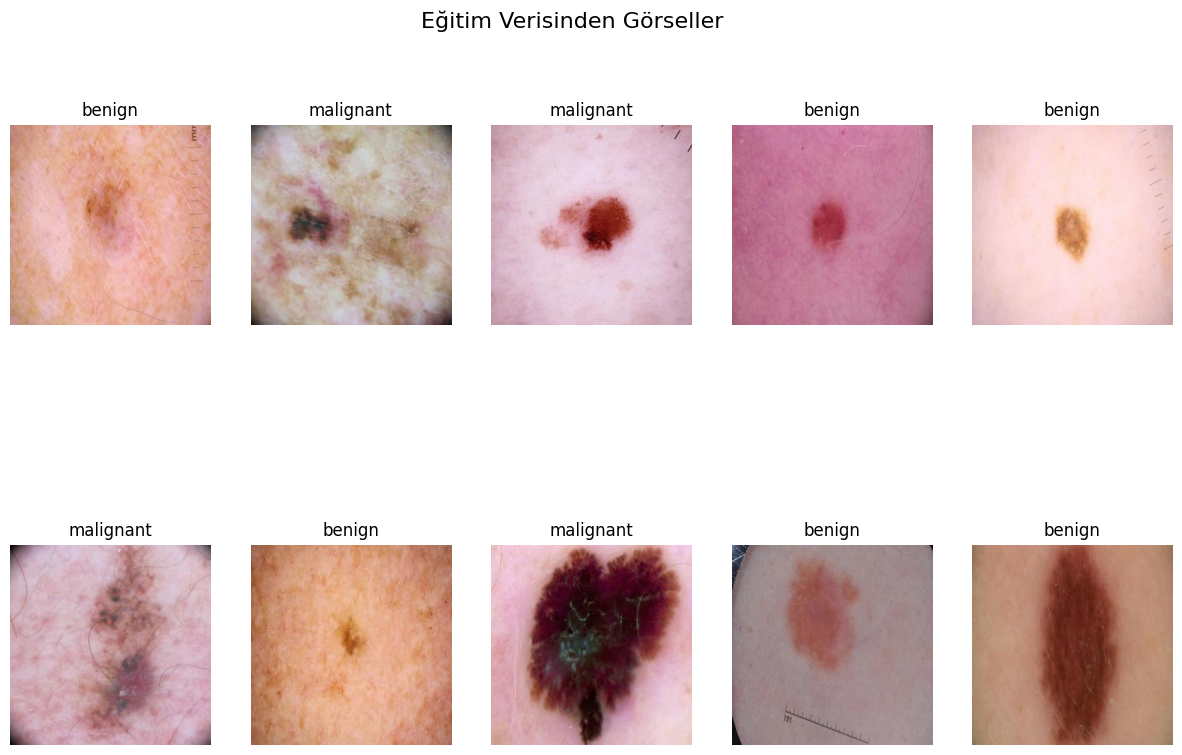

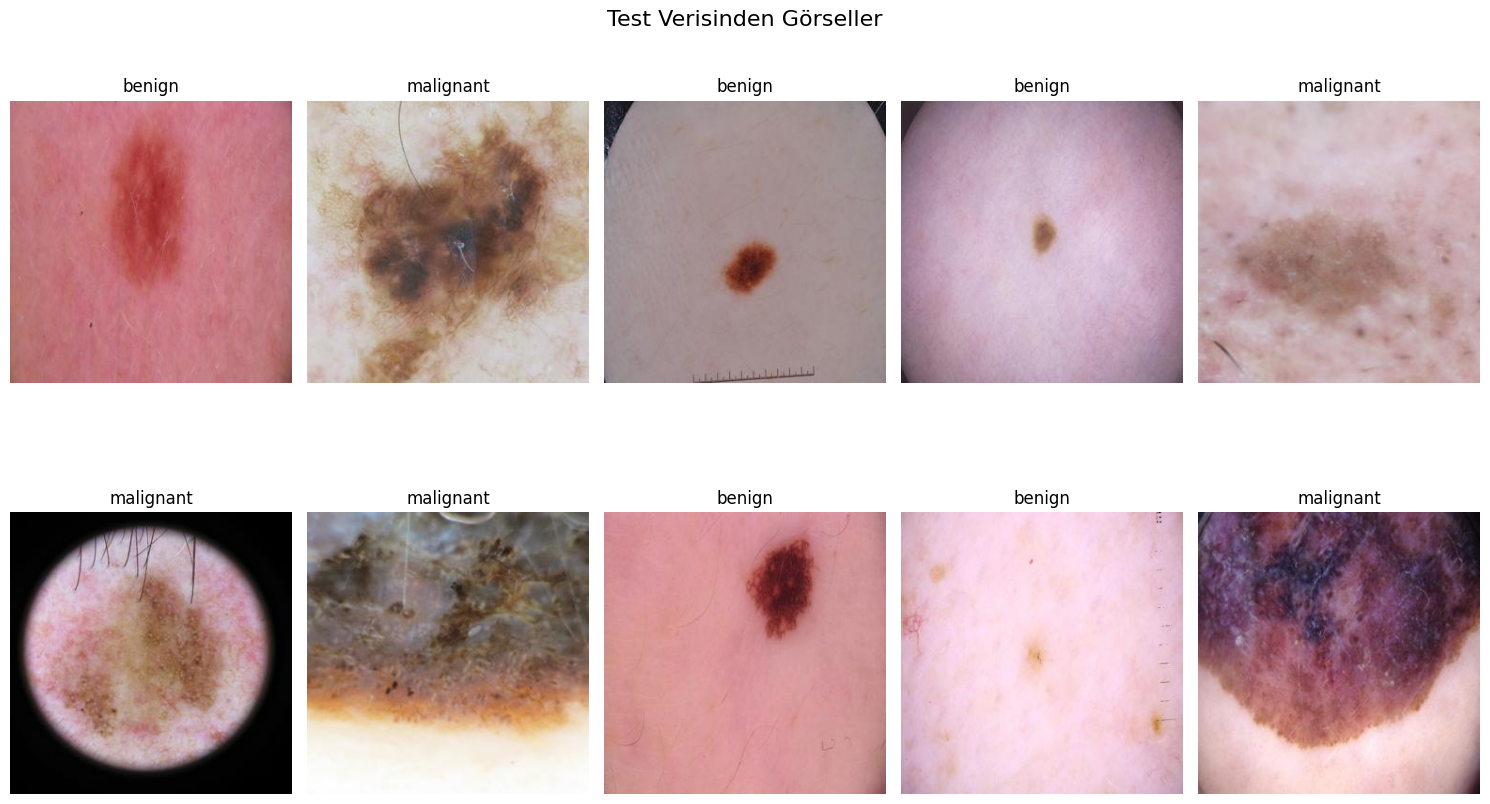

In [6]:

from PIL import Image # python imaging library görselleri yüklemek için kullanılıyor

# Görselleri ve etiketleri görselleştirme fonksiyonu
def visualize_images(dataframe, title, num_images=10):
    plt.figure(figsize=(15, 10))
    plt.suptitle(title, fontsize=16, y=0.92)

    # Rastgele num_images kadar veri seç
    sampled_data = dataframe.sample(num_images)

    for i, (filepath, label) in enumerate(zip(sampled_data['filepaths'], sampled_data['labels'])):
        # Görüntüyü yükle
        image = Image.open(filepath)

        # Görüntüyü göster
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')

# Eğitim verisini görselleştir
visualize_images(train_df,
"Eğitim Verisinden Görseller", num_images=10)

# Test verisini görselleştir
visualize_images(test_df,
"Test Verisinden Görseller", num_images=10)

plt.tight_layout()
plt.show()

In [7]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.preprocessing import LabelEncoder

# Veri dönüştürme işlemleri

# Eğitim verisi için transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # Rastgele çevirme
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Rastgele kırpma
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test verisi için transform (sadece temel işlemler)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# LabelEncoder ile etiketlerin sayısal hale getirilmesi
label_encoder = LabelEncoder()

# Etiketleri sayısal hale getirmek için eğitim ve test veri çerçevesini dönüştürme
train_df['labels'] = label_encoder.fit_transform(train_df['labels'])
test_df['labels'] = label_encoder.transform(test_df['labels'])

# Özelleştirilmiş Dataset sınıfı
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.images = dataframe['filepaths'].values
        self.labels = dataframe['labels'].values.astype(int)  # Sayısal etikete dönüştür

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]  # Sayısal etiketi alın
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.dataframe)  # Dataset'in uzunluğunu döndür

# Eğitim ve test veri setlerinin oluşturulması
train_dataset = SkinCancerDataset(train_df, transform=train_transform)
test_dataset = SkinCancerDataset(test_df, transform=test_transform)

# DataLoader oluşturma
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# İlk örneğin etiketinin tipini kontrol et
print(type(train_dataset[0][1]))  # İlk örneğin etiketinin tipi (int olmalı)
print(train_df['labels'].head())  # Etiketlerin sayısal olduğunu kontrol edin
print(test_df['labels'].head())  # Test etiketlerinin sayısal olduğunu kontrol edin


<class 'numpy.int64'>
0    0
1    0
2    0
3    0
4    0
Name: labels, dtype: int64
0    0
1    0
2    0
3    0
4    0
Name: labels, dtype: int64


In [8]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Dataset'leri oluşturma
train_dataset = SkinCancerDataset(train_df, transform=train_transform)
test_dataset = SkinCancerDataset(test_df, transform=test_transform)

# Eğitim veri kümesini eğitim ve doğrulama olarak ayırma
train_indices, val_indices = train_test_split(
    range(len(train_df)), test_size=0.2, stratify=train_df['labels'], random_state=42
)

# Subset kullanarak eğitim ve doğrulama kümelerini oluşturma
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

# DataLoader'lar ile veri yükleme
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)   # Eğitim verileri için
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)      # Doğrulama verileri için
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)   # Test verileri için




In [10]:
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import os

# Cihazı belirleyin (GPU ya da CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sınıf ağırlıklarını hesaplayın (train_df'deki etiketlere göre)
class_counts = train_df['labels'].value_counts().sort_index()
class_weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float32)
class_weights = class_weights.to(device)  # class_weights tensor'unu device'a taşıyın
# Etiketleri sayısal değerlere dönüştürme

label_encoder = LabelEncoder()
train_df['labels'] = label_encoder.fit_transform(train_df['labels'])
test_df['labels'] = label_encoder.transform(test_df['labels'])

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_classes = len(label_encoder.classes_)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,num_classes)  # İki sınıf: benign, malignant
)
model = model.to(device)  # Modeli device'a taşıyın

# Kayıp fonksiyonu ve optimizasyon
criterion = nn.CrossEntropyLoss(weight=class_weights)  # class_weights burada kullanılıyor
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Küçük bir başlangıç learning rate'i
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)






In [11]:
from imblearn.over_sampling import SMOTE
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Modeli GPU'ya taşıyın (eğer varsa)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10, smote=True, batch_size=16):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Veri dengelemesi için batched SMOTE uygulanacaksa
    if smote:
        print("Applying batched SMOTE for class balancing...")

        all_train_data = []
        label_encoder = LabelEncoder()
        all_train_labels = []

        
        
        # Eğitim verilerini topla ve etiketleri sayısal değerlere dönüştür
        for images, labels in train_loader:
            if isinstance(labels, torch.Tensor):
                labels = labels.numpy()  # Eğer etiketler tensor ise, NumPy dizisine dönüştür
            labels = label_encoder.fit_transform(labels)  # Etiketleri sayısal değerlere dönüştür
            all_train_data.append(images)
            all_train_labels.append(torch.tensor(labels, dtype=torch.long))  # NumPy yerine Tensor olarak ekle

        # Tensorleri birleştir
        all_train_data = torch.cat(all_train_data)
        all_train_labels = torch.cat(all_train_labels)

        # Check if increasing batch size helps
        batch_size = 32  # Increased batch size, if possible
        # Batched SMOTE uygulaması
        smote = SMOTE(random_state=42, k_neighbors=3)  # Reduced n_neighbors to 3

        # Batched SMOTE işlemi
        smote = SMOTE(random_state=42)
        X_res_list, y_res_list = [], []

        for i in range(0, len(all_train_data), batch_size):
            # Batched SMOTE için alt setleri oluştur
            batch_data = all_train_data[i:i + batch_size]
            batch_labels = all_train_labels[i:i + batch_size]

            # SMOTE işlemi
            batch_data_np = batch_data.view(batch_data.size(0), -1).numpy()  # 2D format
            batch_labels_np = batch_labels.numpy()

            if len(set(batch_labels_np)) > 1:  # SMOTE'nin çalışabilmesi için birden fazla sınıf gerekli
                X_res, y_res = smote.fit_resample(batch_data_np, batch_labels_np)
                X_res_list.append(torch.tensor(X_res, dtype=torch.float32))
                y_res_list.append(torch.tensor(y_res, dtype=torch.long))
            else:
                # Eğer tek bir sınıf varsa, veriyi olduğu gibi ekle
                X_res_list.append(batch_data)
                y_res_list.append(batch_labels)

        # SMOTE sonrası veriyi birleştir
        X_res_tensor = torch.cat(X_res_list)
        y_res_tensor = torch.cat(y_res_list)

        # SMOTE sonrası veriyi yeniden şekillendir (4D format: batch_size, channels, height, width)
        X_res_tensor = X_res_tensor.view(-1, 3, 224, 224)  # 3 kanal ve 224x224 boyutundaysa
        print("X_res_tensor shape before reshaping:", X_res_tensor.shape)

        # Yeni eğitim veri kümesi
        train_dataset = TensorDataset(X_res_tensor, y_res_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

    # Eğitim döngüsü
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        total = 0
        correct = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            # Ensure that images and labels are tensors
            images = images.to(device)

            # Etiketleri sayısal hale getirin (eğer hala string ise)
            if isinstance(labels, torch.Tensor):
                labels = labels.to(device)
            else:
                # Eğer etiketler metinse, sayısal hale getir
                labels = label_encoder.transform(labels)
                labels = torch.tensor(labels, dtype=torch.long).to(device)

            # Optimizasyonu sıfırla
            optimizer.zero_grad()

            # İleri geçiş ve kayıp hesaplama
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Geriye doğru geçiş
            loss.backward()
            optimizer.step()

            # Kayıpları ve doğruluğu güncelle
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss /= len(train_loader)
        epoch_acc = (correct / total) * 100
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

        # Öğrenme oranını güncelleme
        if scheduler:
            scheduler.step()

        # Doğrulama kısmı
        model.eval()
        val_loss = 0.0
        val_total = 0
        val_correct = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)

                if isinstance(labels, torch.Tensor):
                    labels = labels.to(device)
                else:
                    labels = label_encoder.transform(labels)
                    labels = torch.tensor(labels, dtype=torch.long).to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = (val_correct / val_total) * 100
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

        model_save_path = f"model_weights_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), model_save_path)
        print(f"Model weights saved to {model_save_path}")

    return train_losses, train_accuracies, val_losses, val_accuracies


# Modeli eğitin
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=10, smote=True, batch_size=16
)

Applying batched SMOTE for class balancing...


KeyboardInterrupt: 

In [15]:
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

# Cihazı ayarlama (GPU veya CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# LabelEncoder'ı sadece eğitim verisi üzerinde eğitin
label_encoder = LabelEncoder()

def fit_label_encoder(train_loader, test_loader):
    all_labels = []
    for images, labels in train_loader:
        if isinstance(labels, torch.Tensor):
            labels = labels.cpu().numpy()
        all_labels.extend(labels)  # Eğitim verisi etiketlerini topla

    label_encoder.fit(all_labels)  # Sadece eğitim verisi ile fit et

    # Test verisi etiketlerini dönüştürme
    all_test_labels = []
    for images, labels in test_loader:
        if isinstance(labels, torch.Tensor):
            labels = labels.cpu().numpy()
        all_test_labels.extend(labels)  # Test verisi etiketlerini topla

    label_encoder.transform(all_test_labels)  # Test etiketlerinin dönüştürülmesini sağla

def transform_labels(labels):
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    return label_encoder.transform(labels)

def evaluate_model_on_test_data(model, test_loader, criterion):
    model.eval()  # Modeli değerlendirme moduna al

    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            labels = transform_labels(labels)  # Etiketleri dönüştür

            images = images.to(device)
            labels = torch.tensor(labels, dtype=torch.int64).to(device)  # Etiketleri tensor'a çevir

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # F1 skoru için tahminler ve etiketleri topla
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_acc = 100 * correct / total
    # F1 skoru hesapla
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # Test verisindeki görsel sayısı
    num_images = total  # Test verisindeki toplam örnek sayısı
    # Classification Report
    report = classification_report(all_labels, all_predictions)
    return test_loss, test_acc, f1, num_images , report

# Eğitim ve test yükleyicilerini kullanarak LabelEncoder'ı eğitin
fit_label_encoder(train_loader, test_loader)

# Test verisi ile modeli değerlendirme
test_loss, test_acc, f1, num_images,report= evaluate_model_on_test_data(model, test_loader, criterion)

# Çıktıları yazdırma
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')
print(f'F1 Score (Weighted): {f1:.4f}')
print(f'Total number of images in the test set: {num_images}')
print("\nClassification Report:\n")
print(report)


Test Loss: 11.8125
Test Accuracy: 90.70%
F1 Score (Weighted): 0.9065
Total number of images in the test set: 1000

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.98      0.91       500
           1       0.97      0.84      0.90       500

    accuracy                           0.91      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000



In [195]:
print(labels[:10])  # İlk birkaç etiketi kontrol edin

tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1])


In [120]:
print(outputs.shape)  # Modelin çıkış boyutunu kontrol edin


torch.Size([32, 2])


In [16]:
num_classes = len(label_encoder.classes_)  # 2 olmalı
print(num_classes)

2


In [22]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import numpy as np

# Modeli yeniden tanımlayın
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_classes = len(label_encoder.classes_)
model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, num_classes)
)

# Modeli Cihaza (GPU veya CPU) taşıyın
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Eğitim sırasında kaydedilen modelin ağırlıklarını yükleyin
model.load_state_dict(torch.load("model_weights_epoch_10.pth", map_location=device))  # X yerine doğru epoch numarasını girin

# Modeli test moduna al
model.eval()

# Görüntü için tahmin yapma fonksiyonu
def predict_image(model, image_path, label_encoder, device):
    # Görüntüyü yükle
    image = Image.open(image_path).convert('RGB')

    # Görüntüye uygun ön işleme yapma (ResNet için)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = transform(image).unsqueeze(0)  # Modelin beklediği format: [1, C, H, W]

    # Görüntüyü cihaza taşı
    image = image.to(device)

    # Modelin tahminini al
    with torch.no_grad():
        outputs = model(image)
        
        # Softmax ile olasılıkları hesapla
        softmax = torch.nn.Softmax(dim=1)
        probabilities = softmax(outputs)
        
        # Tahmin edilen sınıf ve güvenilirlik oranı
        confidence, predicted = torch.max(probabilities, 1)
        confidence = confidence.item() * 100  # Yüzde olarak güvenilirlik oranı

    # Tahmin edilen etiketi geri dönüştür
    predicted_label = label_encoder.inverse_transform([predicted.cpu().numpy()[0]])
    return predicted_label[0], confidence  # Tahmin edilen etiket ve güvenilirlik oranı döndürülür

# Test etmek istediğiniz resmin yolu
image_path = "C:\\Users\\bahar\\melanoma_cancer\\test\\benign\\melanoma_9731.jpg"  # Buraya test etmek istediğiniz resmin yolunu yazın

# Görüntü için tahmin yap
predicted_label, confidence = predict_image(model, image_path, label_encoder, device)
print(f"Predicted label for the image: {predicted_label}")
print(f"Confidence: {confidence:.2f}%")

Predicted label for the image: 0
Confidence: 97.26%


C:\Users\bahar\AppData\Local\Temp\ipykernel_9944\47350820.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_weights_epoch_10.pth",

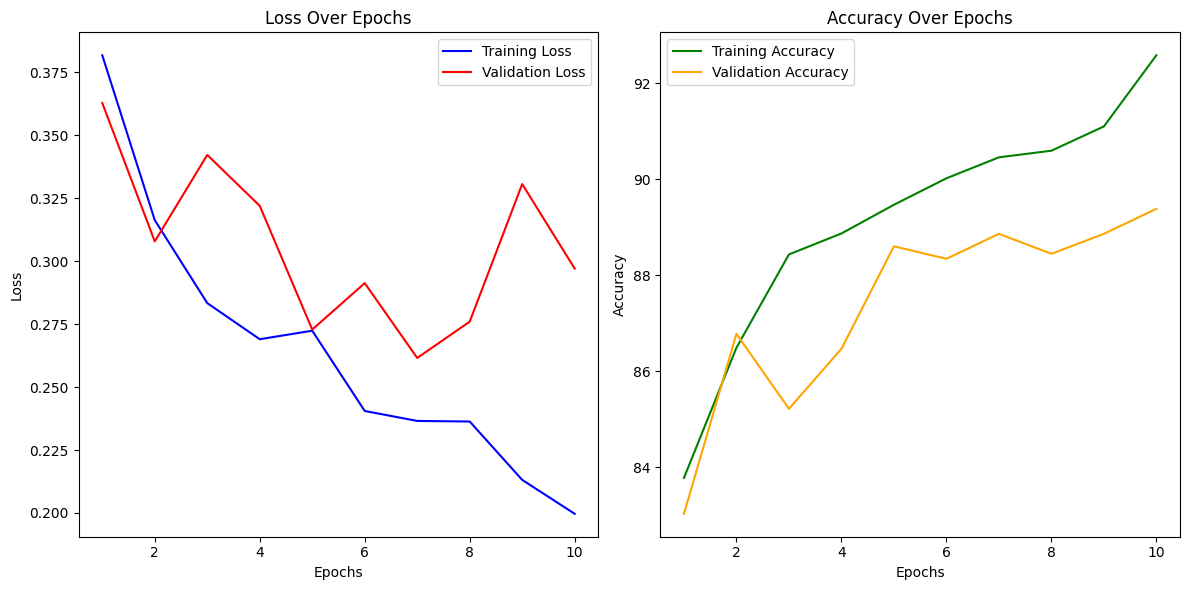

In [16]:
import matplotlib.pyplot as plt

# Kayıp ve doğruluk grafiklerini çizme
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epochs):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 6))

    # Kayıp (Loss) grafiği
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Doğruluk (Accuracy) grafiği
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='green')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Grafik çizme
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epochs=10)


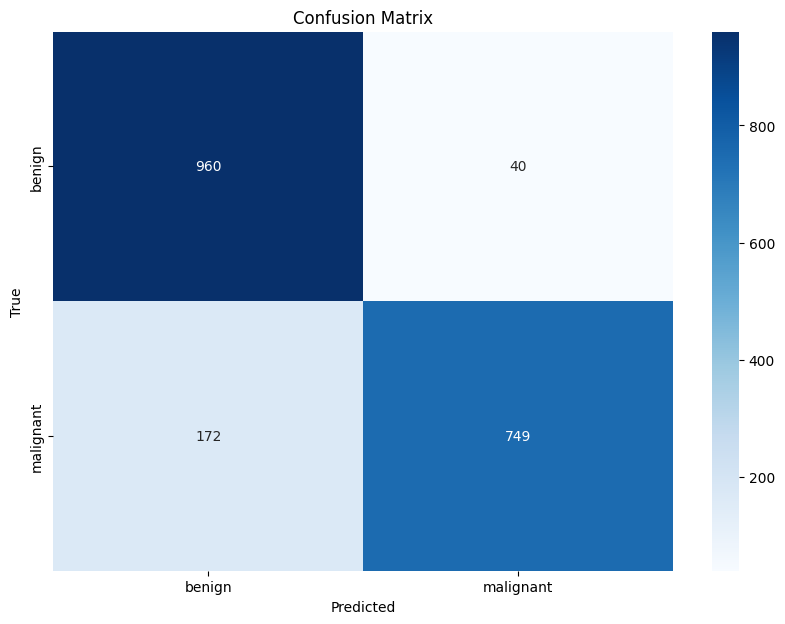

In [18]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, data_loader, label_encoder, device):
    model.eval()
    all_labels = []
    all_predictions = []

    # Modelin tahminleri al
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)

            if isinstance(labels, torch.Tensor):
                labels = labels.to(device)
            else:
                labels = label_encoder.transform(labels)
                labels = torch.tensor(labels, dtype=torch.long).to(device)

            # İleri geçiş
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Confusion matrix hesapla
    cm = confusion_matrix(all_labels, all_predictions)

    # Confusion matrix'i görselleştir
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Kullanım
plot_confusion_matrix(model, val_loader, label_encoder, device)


In [45]:
print(train_df['labels'].unique())  # Eğitim veri setindeki etiketlerin benzersiz değerlerini kontrol et
print(test_df['labels'].unique())   # Test veri setindeki etiketlerin benzersiz değerlerini kontrol et


[0 1]
[0 1]
